# Load Data
kaggle.com/anirudhg15/mammals-classification

In [ ]:
#import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg16 import VGG16
from google.colab import files
from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/tugbes/new/

/content/drive/MyDrive/tugbes/new


In [ ]:
ls

MammalsAugmentasi.h5  train/  val/


# Augmentasi

In [ ]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1,)

In [ ]:
input_shape = (300, 300)

train = '/content/drive/MyDrive/tugbes/new/train'
train_generator = datagen.flow_from_directory(train, 
                                                    target_size=input_shape,
                                                    class_mode ='categorical',
                                                    batch_size = 32,
                                                    color_mode ='rgb',
                                                    shuffle = False) 

validation = '/content/drive/MyDrive/tugbes/new/val'
validation_generator = datagen.flow_from_directory(validation,
                                                        target_size=input_shape,
                                                        class_mode ='categorical',
                                                        color_mode ='rgb',
                                                        batch_size = 32,
                                                        shuffle = False)


Found 635 images belonging to 9 classes.
Found 165 images belonging to 9 classes.


# Modelling

In [ ]:
baseModel = VGG16(include_top=False,  weights='imagenet', input_tensor=Input(shape=(300,300,3)))

In [ ]:
class FCHeadNet:
  def build(baseModel, classes, D):
    headModel = baseModel.output
    headModel = Dropout(0.5)(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(D, activation='relu')(headModel)
    headModel = Dense(classes, activation='sigmoid')(headModel)
    return headModel

In [ ]:
from tensorflow.keras.models import Model

headModel = FCHeadNet.build(baseModel, 9, 512)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
  layer.trainable = False

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", mode="min", verbose=1, patience=10, min_delta=0.0001, factor=0.2)       
directory_to_save_best_model_file = 'VGG19.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [ ]:
Hi = model.fit(
    train_generator, 
    epochs=100, 
    validation_data= validation_generator,
    callbacks = [reduce_lr, best_model]
    )

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 4.8666 - acc: 0.1213
Epoch 00001: val_acc did not improve from 0.70303
20/20 [==============================] - 83s 3s/step - loss: 4.8666 - acc: 0.1213 - val_loss: 3.5304 - val_acc: 0.1333 - lr: 1.0000e-04
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 3.1842 - acc: 0.0866
Epoch 00002: val_acc did not improve from 0.70303
20/20 [==============================] - 51s 3s/step - loss: 3.1842 - acc: 0.0866 - val_loss: 2.1224 - val_acc: 0.1576 - lr: 1.0000e-04
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 2.1370 - acc: 0.2000
Epoch 00003: val_acc did not improve from 0.70303
20/20 [==============================] - 51s 3s/step - loss: 2.1370 - acc: 0.2000 - val_loss: 2.0648 - val_acc: 0.2667 - lr: 1.0000e-04
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 2.1627 - acc: 0.1937
Epoch 00004: val_acc did not improve from 0.70303
20/20 [=========================

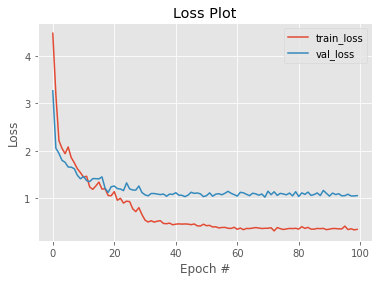

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), Hi.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), Hi.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

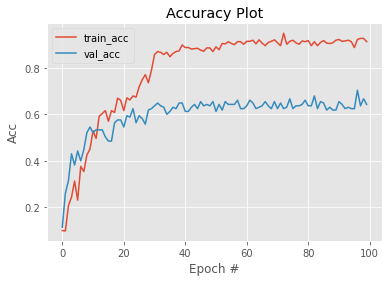

In [ ]:
plt.figure()
plt.plot(np.arange(0, 100), Hi.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), Hi.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
model.save('vgg.h5')

Accuracy: 63.64%


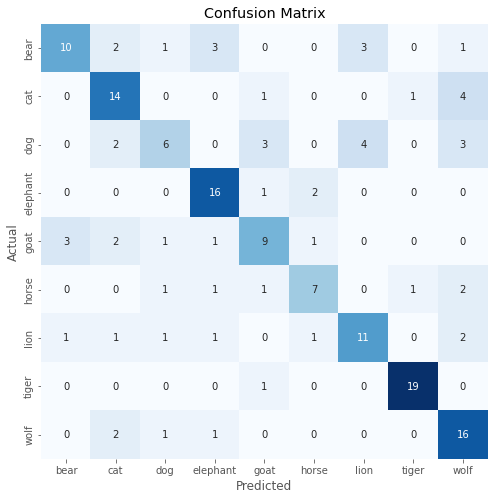

Classification Report:
----------------------
               precision    recall  f1-score   support

        bear       0.71      0.50      0.59        20
         cat       0.61      0.70      0.65        20
         dog       0.55      0.33      0.41        18
    elephant       0.70      0.84      0.76        19
        goat       0.56      0.53      0.55        17
       horse       0.64      0.54      0.58        13
        lion       0.61      0.61      0.61        18
       tiger       0.90      0.95      0.93        20
        wolf       0.57      0.80      0.67        20

    accuracy                           0.65       165
   macro avg       0.65      0.64      0.64       165
weighted avg       0.65      0.65      0.65       165



In [ ]:
import seaborn as sns
target_name = ['bear', 'cat', 'dog', 'elephant', 'goat', 'horse', 'lion', 'tiger', 'wolf']
acc = model.evaluate(validation_generator, verbose=0)
print("Accuracy: {:.2f}%".format(acc[1] * 100))

predictions = np.argmax(model.predict(validation_generator), axis=1)

cm = confusion_matrix(validation_generator.labels, predictions, labels=[0, 1, 2,3,4,5,6,7,8])
clr = classification_report(validation_generator.labels, predictions, labels=[0, 1, 2,3,4,5,6,7,8], target_names=target_name)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], labels=target_name)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], labels=target_name)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

# Prediksi

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np

input_size = (224,224)
channel = (3,)
input_shape = input_size + channel
labels = ['bear', 'cat', 'dog', 'elephant', 'goat', 'horse', 'lion', 'tiger', 'wolf']

In [ ]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [ ]:
from tensorflow.keras.models import load_model

MODEL_PATH = '/content/drive/MyDrive/tugbes/new/vgg.h5'
model = load_model(MODEL_PATH,compile=False)

goat 0.9901074


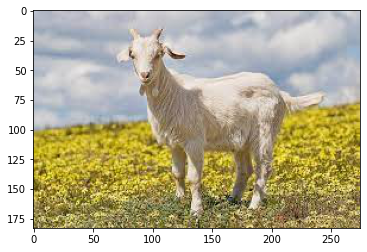

In [ ]:
# read image
im = Image.open('/content/download (2).jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )
plt.imshow(plt.imread("/content/download (2).jpg"))

In [ ]:
def perdict(img):
    class_index = list(validation_generator.class_indices.keys())
    test_img = cv2.imread(img)
    test_img = cv2.resize(test_img, (224, 224))
    test_img = test_img.reshape((1, 224, 224, 3))
    pred = model.predict(test_img)
    return class_index[np.argmax(pred)], max(pred.ravel())

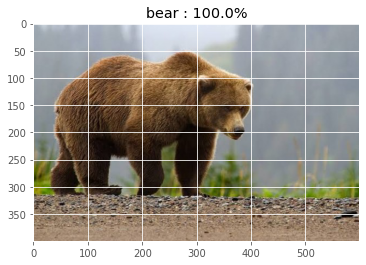

In [ ]:
pred, confidence = perdict("/content/images-d76c54f9e715269fe989a553e3fef842_600x400.jpeg")
plt.imshow(plt.imread("/content/images-d76c54f9e715269fe989a553e3fef842_600x400.jpeg"))
plt.title(f"{pred} : {round(confidence, 2)*100}%")
plt.show()